## Predicting exons with Evo 2 Embeddings

As a result of extensive pretraining, we expect Evo 2 embeddings to capture details of eukaryotic gene architecture. By training a lightweight model on top of Evo 2 embeddings, we can build classifiers to predict genomic annotations. Annotation prediction tools, in combination with bioinformatic approaches, may aid in characterization of non-reference organism genomes. We demonstrate this approach by training a classifier to predict exonic annotation of a genomic position at single-nucleotide resolution. 

Here, we start by loading sample positions. We then extract Evo 2 embeddings for sample positions from diverse eukaryotes, run them through the exon classifier, and demonstrate classification accuracy.

In [1]:
import pandas as pd
positions = pd.read_csv('notebooks/exon_classifier/samplePositions.tsv',sep='\t')
positions

,organism,assembly,gene_name,sequence_record,strand,position,label,forward_seq,reverse_seq
0,Homo_sapiens,GCF_000001405.40,CLCN7,NC_000016.10,-,1453979.0,0.0,atcactttgcttgtgtcttaccaaagatctttgcatccgtggttgt...,ggaagacctgccttcccagccagtgtccacagggcagcaattccac...
1,Homo_sapiens,GCF_000001405.40,PRORP,NC_000014.9,+,35275559.0,1.0,gtcagagggttgtgaatggggtggtcaggaacagcctttctgaggg...,tacaaaaaataaattaaccaggtgtggtggtgtccaccttataggg...
2,Homo_sapiens,GCF_000001405.40,ZNF804B,NC_000007.14,+,88969116.0,0.0,ttccttctgaatccaccaatgattttgtcattgacaaataaccttg...,aaactattcaaaaaaaaaaatagaggatgaaggaatacttccaaac...
3,Homo_sapiens,GCF_000001405.40,VPS8,NC_000003.12,+,184850021.0,1.0,tcagccaagttcattgaggaatgctgaatcctgtataagtgtattt...,cagtcatccttataatttgcttcttccccttctgctccaaggtaac...
4,Homo_sapiens,GCF_000001405.40,GOLGB1,NC_000003.12,-,121729928.0,1.0,ttcattaaaagttaaccaaagaaaatatgatctctaaagttgaaaa...,gggaagaagaatgtcacatactggtgccatttaacataaaatcaca...
...,...,...,...,...,...,...,...,...,...
117,Danio_rerio,GCF_000002035.6,map2,NC_007120.7,+,38833672.0,0.0,agacttgatagcatcagctctctgagtaattcataatgtgagatgt...,gcttataaatcactgaaagagtgcttactgttaattgaattatatt...
118,Danio_rerio,GCF_000002035.6,sgce,NC_007130.7,-,41037095.0,1.0,agccatatcgcactgctaggagtgtgatattgcatttatacaacag...,ttaaagcattacaggtcaaagcaatccgttgttactgtacttgttt...
119,Danio_rerio,GCF_000002035.6,porcnl,NC_007119.7,-,22544340.0,1.0,gctaaatgactctactatactaaactctactatatactcaaagaga...,gctttggatgtgtgttggggtgaggaccctacagacatcatgcaag...
120,Danio_rerio,GCF_000002035.6,si:dkey-7j14.5,NC_007127.7,-,43023144.0,1.0,cttaaacatttattcaaatttatttttaaatattcagaaatgaagc...,atttctcaaattgtgattcgattgaacttgatagatgttgccctgt...


In [2]:
# Load Evo2 model
from evo2 import Evo2

evo2_model = Evo2('evo2_7b_base')

[06/10/25 11:34:05] WARNING  root - WARNING - Supported flash-attn versions are >= 2.1.1, <=       ]8;id=923673;file:///home/jon/projects/evo2/envs/public_evo2/lib/python3.11/site-packages/transformer_engine/pytorch/attention.py\attention.py]8;;\:]8;id=226087;file:///home/jon/projects/evo2/envs/public_evo2/lib/python3.11/site-packages/transformer_engine/pytorch/attention.py#164\164]8;;\
                             2.6.3. Found flash-attn 2.7.4.post1.                                                  

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Found complete file in repo: evo2_7b_base.pt


100%|██████████| 32/32 [00:00<00:00, 243.12it/s]


Extra keys in state_dict: {'blocks.3.mixer.dense._extra_state', 'unembed.weight', 'blocks.31.mixer.dense._extra_state', 'blocks.24.mixer.dense._extra_state', 'blocks.10.mixer.dense._extra_state', 'blocks.17.mixer.dense._extra_state'}


In [3]:
# Function to tokenize and get embedding for the final token in a sequence
import torch

def get_final_token_embedding(sequence, model, layer_name):
    input_ids = torch.tensor(
        model.tokenizer.tokenize(sequence),
        dtype=torch.int,
    ).unsqueeze(0).to('cuda:0')
    with torch.no_grad():
        _, embeddings = model(input_ids, return_embeddings=True, layer_names=[layer_name])
    return embeddings[layer_name][0, -1, :].cpu().to(torch.float32).numpy()  # shape: (hidden_dim,)

In [4]:
# Get Evo 2 embeddings for the each position and append to the dataframe
import numpy as np
from tqdm import tqdm

embedding_list = []
layer_name = 'blocks.26'

for _, row in tqdm(positions.iterrows(), total=len(positions), desc="Extracting embeddings"):
    emb_fwd = get_final_token_embedding(row['forward_seq'], evo2_model, layer_name)
    emb_rev = get_final_token_embedding(row['reverse_seq'], evo2_model, layer_name)
    emb_concat = np.concatenate((emb_fwd, emb_rev))
    embedding_list.append(emb_concat)

# Add to DataFrame
positions['embedding'] = embedding_list

Extracting embeddings: 100%|██████████| 122/122 [01:24<00:00,  1.44it/s]


In [5]:
# Load the lightweight exon classifier
from transformers import AutoModel

exon_classifier = AutoModel.from_pretrained(
    "schmojo/evo2-exon-classifier",
    trust_remote_code=True   # pulls the two .py files
).to('cuda:0')

In [6]:
# Generate exonic probabilities for each sample position
exonic_probs_list = []

for _, row in tqdm(positions.iterrows(), total=len(positions), desc="Calculating exonic probabilities"):
    embedding_tensor = torch.tensor(row['embedding'], dtype=torch.float32).unsqueeze(0).unsqueeze(1).to('cuda:0')
    prob = exon_classifier(embedding_tensor)
    prob_value = prob['logits'].item()
    exonic_probs_list.append(prob_value)

# Add to DataFrame
positions['exon_prob'] = exonic_probs_list

Calculating exonic probabilities: 100%|██████████| 122/122 [00:00<00:00, 1199.94it/s]


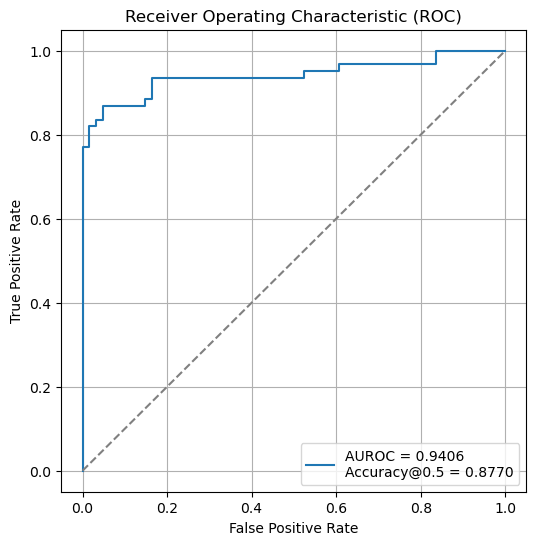

In [7]:
# Plot ROC and display Accuracy (threshold=0.5) and AUROC
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

y_true = positions['label']
y_scores = positions['exon_prob']

# AUROC
auroc = roc_auc_score(y_true, y_scores)

# Accuracy at threshold 0.5
y_pred = (y_scores >= 0.5).astype(int)
accuracy = accuracy_score(y_true, y_pred)

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.4f}\nAccuracy@0.5 = {accuracy:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()